<a href="https://colab.research.google.com/github/Juapatral/reconocimiento_patrones_2020/blob/master/competencia/competencia_crp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Competencia para el curso de Reconocimiento de Patrones
## Universidad Nacional de Colombia - Medellín
## Posgrado en Analítica
## 2020-03-14

---

## Integrantes

* Juan Manuel Marín Quintero
* Juan Camilo Agudelo Marín
* Lina María Grajales Vanegas
* Jhon Anderson Londoño Herrera
* Juan Pablo Trujillo Alviz

## Carga de módulos

Se procede a cargar todas las librerías necesarias así como la documentación de las funciones propias usadas durante el cuaderno.

In [0]:
## carga de liberias  

# basicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
from collections import Counter

# preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb

# validacion cruzada e hiperparametros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

# metricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix

# otras
from IPython.display import clear_output

# ajuste de parametros
pd.set_option('display.max_rows',None)
%matplotlib inline

In [0]:
## bloque de funciones propias

# funcion imprimir mejores parametros para la hiperparametrizacion
def imprimir_parametros(modelo, parametro):
    
    # crear texto del parametro
    texto = "Best " + parametro + ":"

    # imprimir mejor estimado 0
    print(texto, modelo.best_estimator_.get_params()[parametro])
    return (parametro, modelo.best_estimator_.get_params()[parametro])

# funcion descomprimir archivos zip
def descomprimir_zip(url, path = '/content'):

    # abrir url
    with urlopen(url) as zipresp:
            # abrir zio
            with ZipFile(BytesIO(zipresp.read())) as zfile:
                # extraer en el directorio seleccionado
                zfile.extractall(path)

    # devolver cuando ya haya terminado
    return print('Archivo descomprimido')

## Lectura de archivos
En esta sección se descargan los archivos que están disponibles en este [enlace](https://github.com/srobles05/CRP-2019S2-G2/tree/master/Competencia/Datos). 

In [5]:
## descargar archivos

# crear urls
zipurl1 = 'https://raw.githubusercontent.com/srobles05/CRP-2019S2-G2/master/Competencia/Datos/DatosNegativos2.zip'
zipurl2 = 'https://raw.githubusercontent.com/srobles05/CRP-2019S2-G2/master/Competencia/Datos/DatosPositivos2.zip'
zipurl3 = 'https://raw.githubusercontent.com/srobles05/CRP-2019S2-G2/master/Competencia/Datos/DatosValidacion2.zip'

# descomprimir archivos
descomprimir_zip(zipurl1)
descomprimir_zip(zipurl2)
descomprimir_zip(zipurl3)

Archivo descomprimido
Archivo descomprimido
Archivo descomprimido


In [6]:
## lectura de archivos

# leer archivos
datosn = pd.read_csv('/content/DatosNegativos2.csv')
datosp = pd.read_csv('/content/DatosPositivos2.csv')
datosv = pd.read_csv('/content/DatosValidacion2.csv')

# verificar que hayan leido bien
print(datosn.head())
print(datosp.head())
print(datosv.head())

  sequence  length  molecular_weight  ...  embed_2_98  embed_2_99  class
0  MAATRNK       7            790.93  ...    0.017633    0.048197      0
1  MKMDGLR       7            850.06  ...    0.005889    0.083639      0
2  MNIKHYQ       7            933.09  ...   -0.075733    0.013590      0
3  LLWNSIP       7            842.00  ...   -0.169481    0.157881      0
4  MHPHMSY       7            902.05  ...   -0.151773    0.077744      0

[5 rows x 1760 columns]
   Unnamed: 0                   sequence  length  ...  embed_2_98  embed_2_99  class
0           0        CGGYSGGWKRKRSTSYRCG      19  ...   -0.657932    0.072015      1
1           1           GIMISLMKKLAAHIAK      16  ...   -0.274436   -0.125522      1
2           2          FKAWRWAWRMKKLAAPS      17  ...   -0.497003    0.223890      1
3           3       WGWRDIVAGIRKVAAPVLST      20  ...   -0.524435    0.252785      1
4           4  DTHFPICIFCCGCCRQSNCGMCCKT      25  ...   -1.264345   -0.040525      1

[5 rows x 1761 columns]
  

## Análisis exploratorio de datos (EDA)

En esta sección se realiza todo el análisis exploratorio de datos, así como las gráficas y las estadísticas principales.

## Modelado sin selección de variables

En esta sección se propone ajustar 3 diferentes modelos sin hacer una selección de variables previa.

### Preparar los datos

En esta subsección se preparan los datos para el modelado, se eliminan las columnas que no son necesarias y se visualiza si existen desbalanceos o no en la variable objetivo. También se realiza la partición en entrenamiento y pruebas, para posteriormente hacer la estandarización de variables.

In [0]:
## preparar datos los datos

# eliminar columnas de indices de positivos y validacion
datosp.drop(columns='Unnamed: 0', inplace=True)
datosv.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

# unificar
datos = pd.concat([datosn,datosp], ignore_index=True)

# verificar los tipos de datos
contador = Counter([*datos.dtypes])

# se observa que solo existe un tipo de dato object que es sequence

# separar columna de sequencia y clase
y = datos['class']
sequence = datos['sequence']

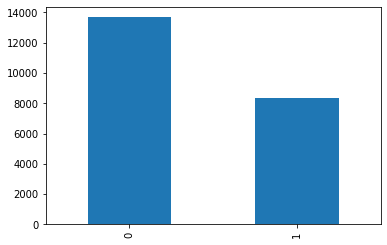

In [8]:
## graficar clase
datos['class'].value_counts().plot(kind='bar');

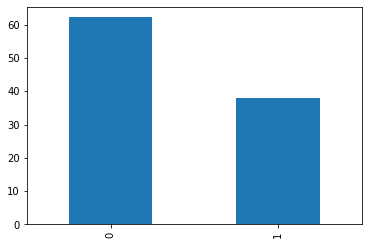

In [9]:
## graficar clase como porcentaje
(datos['class'].value_counts()*100/len(datos)).plot(kind='bar');

In [0]:
## preparar datos para modelar

# quitar columnas
datos.drop(columns=['sequence','class'], inplace = True)

# dividir en entrenamiento y prueba
x_train, x_test, Y_train, Y_test = train_test_split(datos, y, train_size=0.8, 
                                                    random_state=42)

# estandarizar
sc = StandardScaler()
sc.fit(X = x_train.values)
X_train = sc.transform(x_train.values)
X_test = sc.transform(x_test.values)

### Ajustar modelo logístico

Se propone ajustar un modelo de regresión logística.

In [20]:
## validacion cruzada e hiperparametrizacion de regresion logistica

# crear modelo
logit = LogisticRegression(random_state=42)

# parametros
param_dist =  {
    'penalty':['l1', 'l2'],
    'C':np.logspace(-2, 2, 10),
#   'solver':['liblinear', 'lbfgs']
}

# usar validacon cruzada para elegir el mejor modelo                                  
mejor_logit = GridSearchCV(logit, param_dist, cv=5, verbose=2, n_jobs=-1)

mejor_logit.fit(X_train, Y_train)

# limpiar consola
clear_output(wait = True)

# conocer las mejores caracteristicas
[imprimir_parametros(mejor_logit, key) for key in param_dist.keys()]

Best penalty: l2
Best C: 0.01


[('penalty', 'l2'), ('C', 0.01)]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2772
           1       0.83      0.78      0.80      1629

    accuracy                           0.86      4401
   macro avg       0.85      0.84      0.85      4401
weighted avg       0.86      0.86      0.86      4401

Average Time (seconds): 6.428428697586059


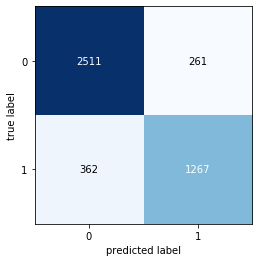

In [21]:
## ajustar logit al mejor modelo 

# crear modelo
mejor_logit = LogisticRegression(penalty='l2', C=0.01, random_state=42)

# ajustar por cv
score = cross_validate(mejor_logit, X_train, Y_train, n_jobs=-1, verbose=0)

# ajustar logit
mejor_logit.fit(X_train, Y_train)

# predecir
y_logit_train = mejor_logit.predict(X_train)
y_logit_test = cross_val_predict(mejor_logit, X_test, Y_test)

# mostrar matriz de metricas
print(classification_report(Y_test, y_logit_test, target_names=['0', '1']))

# mostrar tiempo de modelado
print("Average Time (seconds):", np.mean(score['fit_time']))

# graficar
cm = confusion_matrix(Y_test, y_logit_test)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

### Ajustar modelo de árbol de clasificación

Se propone ajustar un modelo de árbol de clasificación.

In [0]:
## validacion cruzada e hiperparametrizacion de arbol de clasificacion

# crear modelo
dtc = DecisionTreeClassifier(random_state = 42)

# parametros
param_dist =  {
    "max_depth": [9, 10, 11, 12, 13, 14, 15],
    "max_features": [11, 12, 13, 14, 15],
    "min_samples_leaf": [8, 9, 10],
    "min_samples_split": [2,3,4,5,6,7,8,9],
    "criterion": ["gini", "entropy"]
}

# usar validacon cruzada para elegir el mejor modelo                                  
mejor_dtc = GridSearchCV(dtc, param_dist, cv=5, verbose=2, n_jobs=-1)
mejor_dtc.fit(X_train, Y_train)
                                
# limpiar consola
clear_output(wait = True)

# conocer las mejores caracteristicas
[imprimir_parametros(mejor_dtc, key) for key in param_dist.keys()]

Fitting 5 folds for each of 1680 candidates, totalling 8400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 933 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1378 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 1905 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:  1.6min


In [0]:
## ajustar logit al mejor modelo 

# crear modelo
mejor_dtc = DecisionTreeClassifier(max_depth=12, 
                                   max_features=13, 
                                   min_samples_leaf=9,
                                   min_samples_split=2,
                                   criterion='entropy',
                                   random_state=42)

# ajustar por cv
score = cross_validate(mejor_dtc, X_train, Y_train, n_jobs=-1, verbose=0)

# ajustar
mejor_dtc.fit(X_train, Y_train)

# predecir
y_dtc_train = mejor_dtc.predict(X_train)
y_dtc_test = cross_val_predict(mejor_dtc, X_test, Y_test)

# mostrar matriz de metricas
print(classification_report(Y_test, y_dtc_test, target_names=['0', '1']))

# mostrar tiempo de modelado
print("Average Time (seconds):", np.mean(score['fit_time']))

# graficar
cm = confusion_matrix(Y_test, y_dtc_test)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

### Ajustar modelo XGBoost

Se propone ajustar un Extreme Gradient Boosting. 

In [16]:
## validacion cruzada e hiperparametrizacion de maquinas de vectores de soporte

# crear modelo
xgbc = xgb.XGBClassifier(learning_rate=0.02, 
                         n_estimators=600, 
                         objective='binary:logistic',
                         silent=True, 
                         nthread=1,
                         random_state=42)

# parametros
param_dist =  {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}
                                  
# usar validacon cruzada para elegir el mejor modelo                                  
mejor_xgb = RandomizedSearchCV(xgbc, param_dist, cv=5, verbose=2, n_jobs=30)

mejor_xgb.fit(X_train, Y_train)

# limpiar consola
clear_output(wait = True)

# conocer las mejores caracteristicas
l = [imprimir_parametros(mejor_xgb, key) for key in param_dist.keys()]


NameError: ignored

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2772
           1       0.91      0.79      0.85      1629

    accuracy                           0.89      4401
   macro avg       0.90      0.87      0.88      4401
weighted avg       0.90      0.89      0.89      4401

Average Time (seconds): 871.4737900733948


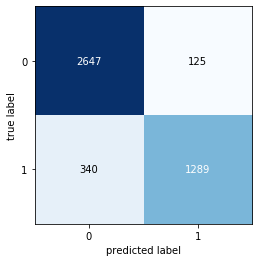

In [19]:
## ajustar svc al mejor modelo 

# crear modelo
# crear modelo
mejor_xgbc = xgb.XGBClassifier(mmin_child_weight=1,
                               gamma=2,
                               subsample=1.0,
                               colsample_bytree=1.0,
                               max_depth=5,
                               learning_rate=0.02,
                               n_estimators=600, 
                               objective='binary:logistic',
                               silent=True, 
                               nthread=1,
                               random_state=42)

# ajustar por cv
score = cross_validate(mejor_xgbc, X_train, Y_train, n_jobs=-1, verbose=0)

# ajustar
mejor_xgbc.fit(X_train, Y_train)

# predecir
y_xgb_train = mejor_xgbc.predict(X_train)
y_xgb_test = cross_val_predict(mejor_xgbc, X_test, Y_test)

# mostrar matriz de metricas
print(classification_report(Y_test, y_xgb_test, target_names=['0', '1']))

# mostrar tiempo de modelado
print("Average Time (seconds):", np.mean(score['fit_time']))

# graficar
cm = confusion_matrix(Y_test, y_xgb_test)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()